# ОПФ для DTMF

Рассмотрим ОПФ на сигналах, полученных из технологии DTMF

In [1]:
from scipy.io import wavfile 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

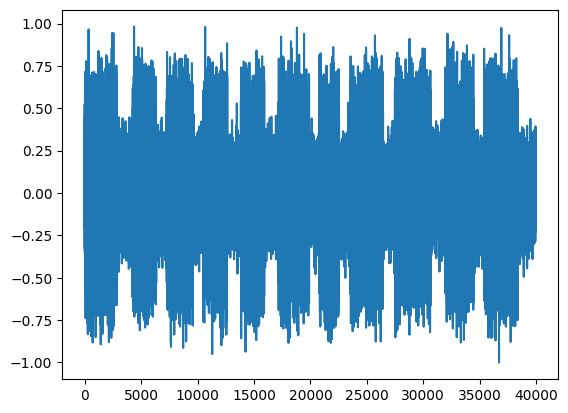

In [2]:
# подгрузка аудиофайла
filename = "source/signals/phoneNumber0.wav"
fs, audio_signal = wavfile.read(filename)
# график
plt.plot(audio_signal)

Построим спектр.

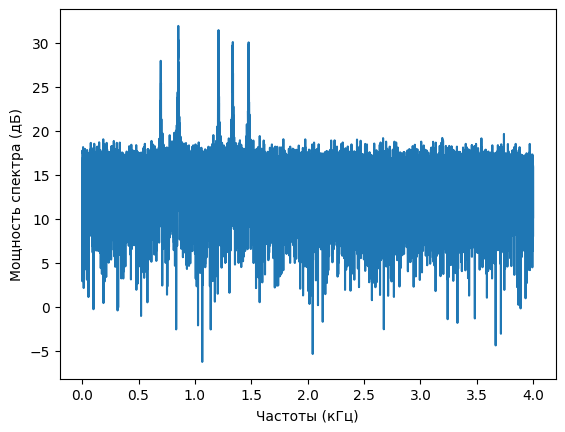

In [3]:
n = len(audio_signal) 
signalFFT = fft(audio_signal)
signalFFT = signalFFT[0:int(np.ceil((n+1)/2.0))] #берём половину спектра
signalFFT_mag = np.abs(signalFFT) # Magnitude
 

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(signalFFT_mag)) #Power spectrum
plt.xlabel('Частоты (кГц)'); plt.ylabel('Мощность спектра (дБ)');

Построим спектрограмму. Для этого надо создать экземпляр класса `signal.ShortTimeFFT` с необходимыми параметрами и использовать метод `stft()` для преобразования сигнала.



In [4]:
from scipy import signal

N = 512 # число точек для ДПФ
SFT = signal.ShortTimeFFT(signal.windows.boxcar(N), hop=int(N/2), fs=fs)#,  scale_to='magnitude')
Sx = SFT.stft(audio_signal)  

# Старый вариант STFT
#f, t, Sxx = signal.spectrogram(audio_signal, window = signal.windows.boxcar(512), fs = fs, nfft=512)

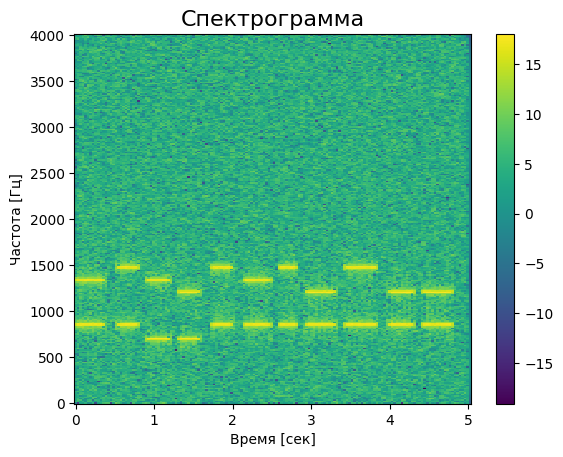

In [5]:
plt.figure()
plt.pcolormesh(SFT.t(len(audio_signal)), SFT.f, 10*np.log10(abs(Sx))) # dB spectrogram
#plt.pcolormesh(SFT.t(len(audio_signal)), SFT.f, abs(Sx))
plt.ylabel('Частота [Гц]')
plt.xlabel('Время [сек]')
plt.title('Спектрограмма',size=16);
plt.colorbar()

plt.show()

Можно использовать различные типы окон.

In [6]:
window = signal.windows.boxcar(51)
window

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

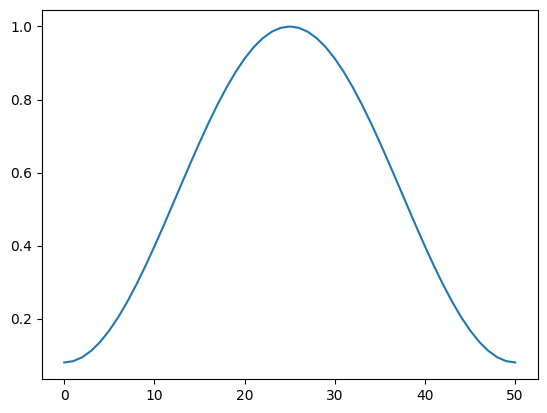

In [7]:
plt.plot(signal.windows.hamming(51))

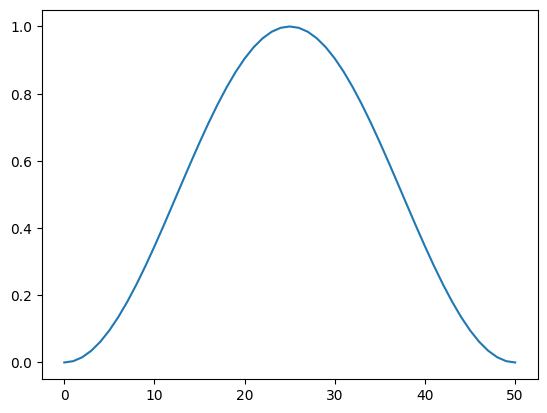

In [8]:
plt.plot(signal.windows.hann(51))

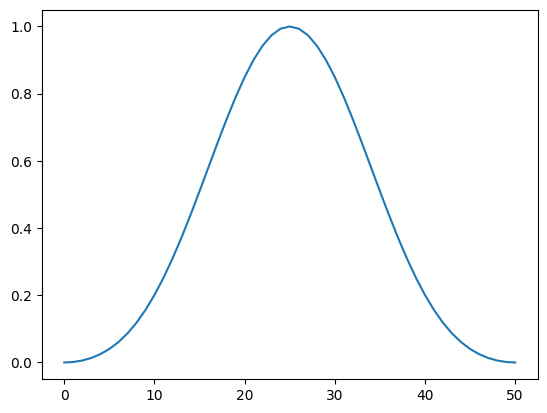

In [9]:
plt.plot(signal.windows.blackman(51))

# ОПФ в задачах классификации

ОПФ для аудио-сигналов часто используют, чтобы выделить признаки аудио-сигналов, которые далее можно использовать в задачах классификации или синтеза звуков.

Рассмотрим задачу класификации звуков с помощью свёрточных нейронных сетей, которые на вход принимают результат ОПФ.

Требуемые библиотеки:
    
    librosa
    torch
    
Рассмотрим датасет ESC-10 из 400 аудио-файлов с записью окружающих звуков. В датасете 10 классов, 40 треков на класс, 5 секунд на файл.

Ссылка на датасет: 
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/YDEPUT/B3VNQW&version=2.0

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

Библиотека librosa содержит основные инструменты для работы с аудио-сигналами.

Загрузим сигнал и построим его спектрограмму.

In [12]:
data, fs = librosa.load("dataset/001 - Dog bark/1-30344-A.ogg", sr=44000) 
data.shape
time_sec = (len(data)/fs)
print('Длительность сигнала: ', time_sec)

C:\Users\Tebemixer\AppData\Local\Temp\ipykernel_7784\3857508041.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  data, fs = librosa.load("dataset/001 - Dog bark/1-30344-A.ogg", sr=44000)
G:\obrabotka_signalov\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/001 - Dog bark/1-30344-A.ogg'

Выведем график сигнала и озвучим сигнал.

In [ ]:
import IPython
IPython.display.Audio(data, rate=fs)

In [ ]:
plt.plot(np.arange(0,len(data))/fs,data)

Проделаем ОПФ с помощью метода `librosa.stft()`.
Приведём значения в шкалу дБ, где максимум соответствует 0 дБ.

Метод по умолчанию имеет ширину окна 2048 точек. Расстояние между соседними окнами 512 точек. Также по умолчанию используется окно Ханна.

In [13]:
freq = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
print('Размер матрицы ОПФ сигнала:', freq.shape)
plt.axis('off') # no axis
librosa.display.specshow(freq)
plt.colorbar(format='%+2.0f dB')
plt.title('ОПФ')

NameError: name 'data' is not defined

### Задача

Сформировать модель и обучить на датасете ESC-10.

Цель: обучить модель с точностью accuracy 80% на тестовой выборке.

Основные шаги:

1. Подгрузить файлы, как набор пар (файл, метка класса)
2. Применить STFT к аудио-сигналам, подобрав подходящие параметры. Обеспечить одинаковый размер массивов на выходе.
3. Разделить данные на обучающую и тестовую выборки.
4. Подобрать архитектуру свёрточной ИНС и обучить модель.

Функция ошибки - это кросс-энтропия.

    loss_fn = nn.CrossEntropyLoss()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Dataset class for ESC-50
def load_metadata(csv_path):
    import pandas as pd
    meta = pd.read_csv(csv_path)
    return meta

class ESC50Dataset(Dataset):
    def __init__(self, meta, audio_dir, sr=22050, n_fft=1024, hop_length=512, n_mels=128):
        self.meta = meta
        self.audio_dir = audio_dir
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        file_path = os.path.join(self.audio_dir, row['filename'])
        # Load audio
        y, sr = librosa.load(file_path, sr=self.sr)
        # Compute STFT magnitude
        S = np.abs(librosa.stft(y, n_fft=self.n_fft, hop_length=self.hop_length))
        # Convert to Mel scale
        mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=self.n_mels)
        log_mel = librosa.power_to_db(mel)
        # Normalize
        log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-9)
        # To tensor
        tensor = torch.FloatTensor(log_mel[np.newaxis, ...])
        label = torch.LongTensor([row['target']])[0]
        return tensor, label

# Residual block
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ResNet-like CNN
def build_resnet(block, layers, num_classes=50):
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet, self).__init__()
            self.in_channels = 64
            self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn = nn.BatchNorm2d(64)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.layer1 = self._make_layer(block, 64, layers[0])
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, out_channels, blocks, stride=1):
            downsample = None
            if stride != 1 or self.in_channels != out_channels:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels),
                )
            layers = []
            layers.append(block(self.in_channels, out_channels, stride, downsample))
            self.in_channels = out_channels
            for _ in range(1, blocks):
                layers.append(block(out_channels, out_channels))
            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv(x)
            x = self.bn(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x

    return ResNet()


# Paths
meta_csv = 'ESC-50-master/meta/esc50.csv'
audio_dir = 'ESC-50-master/audio'
# Load metadata
meta = load_metadata(meta_csv)
# Split
train_meta, val_meta = train_test_split(meta, test_size=0.2, stratify=meta['target'], random_state=42)
# Datasets
train_ds = ESC50Dataset(train_meta, audio_dir)
val_ds = ESC50Dataset(val_meta, audio_dir)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_resnet(ResidualBlock, [2,2,2,2], num_classes=50).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 30
best_acc = 0.0
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}')
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model.pth')
print(f'Best validation accuracy: {best_acc:.4f}')
